<a href="https://colab.research.google.com/github/sunnyl94/Data-Analysis-Folder/blob/main/Retail_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **마케팅 고객 데이터 분석**



> Business Problem

> Data Description

출처 https://www.kaggle.com/datasets/darpan25bajaj/retail-case-study-data



In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [2]:
# 필요한 library 설치
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='NanumBarunGothic')

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 데이터 임포트
customer = pd.read_csv("/content/drive/MyDrive/workspace/Data Analysis/Retail Case Study/data/Customer.csv")
transaction = pd.read_csv("/content/drive/MyDrive/workspace/Data Analysis/Retail Case Study/data/Transactions.csv")
prod_info = pd.read_csv("/content/drive/MyDrive/workspace/Data Analysis/Retail Case Study/data/prod_cat_info.csv")

In [4]:
print("customer: ", customer.shape)
print("transaction: ", transaction.shape)
print("prod_info: ", prod_info.shape)

customer:  (5647, 4)
transaction:  (23051, 10)
prod_info:  (23, 4)


---
# **1. 데이터 전처리**



In [5]:
# DOB (Date of Birth) 컬럼이 object 타입으로 설정되어 있어 날짜로 변환 필요
customer.dtypes

customer_Id      int64
DOB             object
Gender          object
city_code      float64
dtype: object

In [6]:
customer["DOB"] = pd.to_datetime(customer["DOB"])
customer.dtypes

customer_Id             int64
DOB            datetime64[ns]
Gender                 object
city_code             float64
dtype: object

In [7]:
# null value가 없다
transaction.isnull().sum()

transaction_id      0
cust_id             0
tran_date           0
prod_subcat_code    0
prod_cat_code       0
Qty                 0
Rate                0
Tax                 0
total_amt           0
Store_type          0
dtype: int64

In [8]:
# tran_date 컬럼이 object 타입으로 설정되어 있어 날짜로 변환이 필요
transaction.dtypes

transaction_id        int64
cust_id               int64
tran_date            object
prod_subcat_code      int64
prod_cat_code         int64
Qty                   int64
Rate                  int64
Tax                 float64
total_amt           float64
Store_type           object
dtype: object

In [9]:
transaction["tran_date"] = pd.to_datetime(transaction['tran_date'])
transaction.dtypes

transaction_id               int64
cust_id                      int64
tran_date           datetime64[ns]
prod_subcat_code             int64
prod_cat_code                int64
Qty                          int64
Rate                         int64
Tax                        float64
total_amt                  float64
Store_type                  object
dtype: object

In [10]:
# null value가 없다
prod_info.isnull().sum()

prod_cat_code        0
prod_cat             0
prod_sub_cat_code    0
prod_subcat          0
dtype: int64

In [11]:
# 각 컬럼 타입들이 잘 매칭되어 있다
prod_info.dtypes

prod_cat_code         int64
prod_cat             object
prod_sub_cat_code     int64
prod_subcat          object
dtype: object

## 1.a 파생 데이터









> 데이터가 2014년도에 만들어진 데이터이기 떄문에 2014년도 기준 고객 (만)나이 컬럼을 생성해줄 필요가 있다



In [12]:
customer['age'] = 2014 - customer["DOB"].dt.year
display(customer)

,customer_Id,DOB,Gender,city_code,age
0,268408,1970-02-01,M,4.0,44
1,269696,1970-07-01,F,8.0,44
2,268159,1970-08-01,F,8.0,44
3,270181,1970-10-01,F,2.0,44
4,268073,1970-11-01,M,1.0,44
...,...,...,...,...,...
5642,274474,1992-12-19,M,2.0,22
5643,267666,1992-12-24,M,6.0,22
5644,270476,1992-12-25,F,3.0,22
5645,269626,1992-12-27,F,5.0,22


> 주문 건수, 취소 건수, 상품 전환율을 분석하기 위해 거래 상태를 구분할 수 있는 컬럼이 필요

> transaction table에 "Order_status" 컬럼을 추가
*   상품이 취소 되었으면 "cancel"
*   상품이 주문 되었으면 "order"

In [13]:
transaction["order_status"] = np.where(transaction["Qty"] < 0, "cancel", "order")
transaction.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,order_status
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,cancel
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop,cancel
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop,cancel
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop,cancel
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop,cancel


In [14]:
transaction.shape

(23051, 11)



> transaction table에 "confirmed" 컬럼을 추가

1.   상품이 [주문 후 취소] 되었거나 혹은 원래 [취소] 상태였으면 되었으면 "cancel"
2.   상품이 주문 [완료] 되었으면 "confirmed"





In [15]:
# 주문이 완전히 취소된 행만을 추출한 후 "Order_status"를 새로 추가할 "confirmed"라는 컬럼명으로 바꾼다
cancel_confirmed = transaction[transaction["order_status"] == "cancel"][["transaction_id", "order_status"]].drop_duplicates().rename(columns={"order_status":"confirmed"})

# transaction table과 cancel_confirmed table을 합쳐 주문 후 취소한 상품 표시
transaction = pd.merge(transaction, cancel_confirmed, on="transaction_id", how="left")

# NaN value를 주문 되었다는 "confirmed"로 바꾸기
transaction["confirmed"] = transaction["confirmed"].replace(np.nan, "confirm")

transaction.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,order_status,confirmed
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,cancel,cancel
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop,cancel,cancel
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop,cancel,cancel
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop,cancel,cancel
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop,cancel,cancel


In [16]:
num_cancel = transaction[transaction["order_status"] == "cancel"]["order_status"].count()
num_order = transaction[transaction["order_status"] == "order"]["order_status"].count()
num_confirm = transaction[transaction["confirmed"] == "confirm"]["confirmed"].count()

print(num_order, num_cancel, num_order - num_cancel, num_confirm)

20876 2175 18701 18819



> 문제: 총 주문 건수에서 총 취소 건수를 뺀 결과값과 "confirmed" 컬럼에서 확정된 총 주문수 불일치<br>
이상치 혹은 결측치가 존재한다는 뜻이기에 제거 필요




## 1.b 이상치 / 결측치 데이터 처리

### 1.b.i 이상치

In [17]:
transaction["transaction_id"].value_counts()

4170892941     4
32263938079    4
426787191      4
38053958046    3
89232425133    3
              ..
90835310705    1
36310127403    1
8422252533     1
96247253460    1
77960931771    1
Name: transaction_id, Length: 20876, dtype: int64



> 하나의 transaction id에 최대 2개 row가 존재할 수 있지만 확인 결과 3개 이상의 row가 있는것이 확인 됨




In [18]:
# transaction id는 같아도 tran_date가 다를 수 있기 때문에 drop_duplicates()는 사용 불가
# transaction id와 order_status를 비교 후 중복으로 들어간 행만 제거 필요


# transaction id와 order_status의 내용을 합친 리스트를 만들고 transaction table에 추가
key = map(lambda id, status : str(id) + str(status), transaction["transaction_id"], transaction["order_status"])
transaction["key"] = list(key)
transaction.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,order_status,confirmed,key
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,cancel,cancel,80712190438cancel
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop,cancel,cancel,29258453508cancel
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop,cancel,cancel,51750724947cancel
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop,cancel,cancel,93274880719cancel
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop,cancel,cancel,51750724947cancel


In [19]:
# transaction table을 cust_id, transaction_id, tran_date 순으로 정렬 
transaction.sort_values(by=["cust_id", "transaction_id", "tran_date"], inplace=True, ignore_index=True)

In [20]:
# duplicate가 있는지 확인
# 1이면 중복이 아니고 0이면 중복
transaction["chk"] = np.where(transaction["key"] != transaction["key"].shift(-1), 1, 0)

# 1인것만 남기기
filtered_trans = transaction[transaction["chk"] == 1].reset_index(drop=True)

In [21]:
num_cancel = filtered_trans[filtered_trans["order_status"] == "cancel"]["order_status"].count()
num_order = filtered_trans[filtered_trans["order_status"] == "order"]["order_status"].count()
num_confirm = filtered_trans[filtered_trans["confirmed"] == "confirm"]["confirmed"].count()

print(num_order, num_cancel, num_order - num_cancel, num_confirm)

20876 2057 18819 18819


### 1.b.ii 결측치

In [22]:
# Gender와 city_code 컬럼에 각각 2개의 null value가 존재
customer.isnull().sum()

customer_Id    0
DOB            0
Gender         2
city_code      2
age            0
dtype: int64

In [23]:
# Gener는 M,F,none으로 세개의 범주를 만들어 결측치 해결
customer.fillna(value={"Gender":"none"}, inplace=True)

In [24]:
# city_code는 최빈값으로 결측치 해결
customer.fillna(value={"city_code":customer["city_code"].mode()[0]}, inplace=True)

## 1.c 테이블 조인

> Transaction Table안에 category code가 존재하지만 명칭이 없기 때문에 Transaction table과 prod_cat_info Table을 조인 필요



In [25]:
filtered_trans.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,order_status,confirmed,key,chk
0,8410316370,266783,2013-02-20,4,1,1,869,91.245,960.245,e-Shop,order,confirm,8410316370order,1
1,16999552161,266783,2013-02-09,10,5,2,835,175.350,1845.350,e-Shop,order,confirm,16999552161order,1
2,25890929042,266783,2011-09-23,1,2,4,1321,554.820,5838.820,e-Shop,order,cancel,25890929042order,1
3,25890929042,266783,2011-09-24,1,2,-4,-1321,554.820,-5838.820,e-Shop,cancel,cancel,25890929042cancel,1
4,98477711300,266783,2012-10-21,4,1,3,93,29.295,308.295,TeleShop,order,confirm,98477711300order,1


In [26]:
prod_info.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


In [27]:
# prod_cat_code 컬럼명은 같지만 prod_subcat_code 컬럼명은 다르기 때문에 조인을 쉽게 하기 위해 prod_info 테이블의 컬럼명을 transaction 테이블의 컬럼명과 똑같이 만들어 준다

prod_info.rename(columns= {"prod_sub_cat_code":"prod_subcat_code"}, inplace=True)
prod_info.head()

,prod_cat_code,prod_cat,prod_subcat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


In [28]:
# prod_info 테이블과 transaction 테이블 조인 진행

new_data = pd.merge(
    left = filtered_trans,
    right = prod_info,
    on = ["prod_cat_code", "prod_subcat_code"],
    how = "left"
)

new_data.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,order_status,confirmed,key,chk,prod_cat,prod_subcat
0,8410316370,266783,2013-02-20,4,1,1,869,91.245,960.245,e-Shop,order,confirm,8410316370order,1,Clothing,Mens
1,16999552161,266783,2013-02-09,10,5,2,835,175.350,1845.350,e-Shop,order,confirm,16999552161order,1,Books,Non-Fiction
2,25890929042,266783,2011-09-23,1,2,4,1321,554.820,5838.820,e-Shop,order,cancel,25890929042order,1,Footwear,Mens
3,25890929042,266783,2011-09-24,1,2,-4,-1321,554.820,-5838.820,e-Shop,cancel,cancel,25890929042cancel,1,Footwear,Mens
4,98477711300,266783,2012-10-21,4,1,3,93,29.295,308.295,TeleShop,order,confirm,98477711300order,1,Clothing,Mens


---

# **2. 데이터 분석**

## 2.a 상품 전환율

> 주문 거래 건 중 취소가 발생되지 않고 구매가 확정된 거래 건 비중

**질문**
> 1. 고관여 상품군의 상품 전환율이 높을 것인가?<br>
        고관여 상픔의 특징
        1. 구매 전 상품에 대한 탐색 과정이 길다
        2. 거래 비용 발생이 상대적으로 크다



In [29]:
# prod_cat별 최종 구매 및 취소 수
cvr = new_data.groupby(["prod_cat"])["confirmed"].value_counts().unstack()

# 전체 구매
cvr["total"] = new_data.groupby(["prod_cat"])["confirmed"].count()

# 모든 제품을 위한 total 만들기
sum = cvr.sum()
sum.name = "Total"

cvr = cvr.append(sum.transpose())

# 상품 전환율
cvr["CVR(%)"] = ((cvr["confirm"] / cvr["total"]) * 100).round(1)
display(cvr)

confirmed,cancel,confirm,total,CVR(%)
prod_cat,,,,
Bags,392,1593,1985,80.3
Books,1106,4933,6039,81.7
Clothing,540,2406,2946,81.7
Electronics,784,4093,4877,83.9
Footwear,544,2436,2980,81.7
Home and kitchen,748,3358,4106,81.8
Total,4114,18819,22933,82.1


In [30]:
# prod_subcat별 최종 구매 및 취소 수
cvr_subcat = new_data.groupby(["prod_cat", "prod_subcat"])["confirmed"].value_counts().unstack()

# 전체 구매
cvr_subcat["total"] = new_data.groupby(["prod_cat", "prod_subcat"])["confirmed"].count()

# 상품 전환율
cvr_subcat["CVR(%)"] = ((cvr_subcat["confirm"] / cvr_subcat["total"]) * 100).round(1)
display(cvr_subcat)

confirmed                             cancel  confirm  total  CVR(%)
prod_cat         prod_subcat                                        
Bags             Mens                    188      809    997    81.1
                 Women                   204      784    988    79.4
Books            Academic                194      766    960    79.8
                 Children                192      838   1030    81.4
                 Comics                  188      834   1022    81.6
                 DIY                     160      825    985    83.8
                 Fiction                 202      839   1041    80.6
                 Non-Fiction             170      831   1001    83.0
Clothing         Kids                    166      818    984    83.1
                 Mens                    178      785    963    81.5
                 Women                   196      803    999    80.4
Electronics      Audio and video         142      806    948    85.0
                 Cameras                 166      815    981    83.1
                 Computers               160      796    956    83.3
                 Mobiles                 162      866   1028    84.2
                 Personal Appliances     154      810    964    84.0
Footwear         Kids                    170      831   1001    83.0
                 Mens                    176      761    937    81.2
                 Women                   198      844   1042    81.0
Home and kitchen Bath                    188      829   1017    81.5
                 Furnishing              188      812   1000    81.2
                 Kitchen                 206      829   1035    80.1
                 Tools                   166      888   1054    84.3

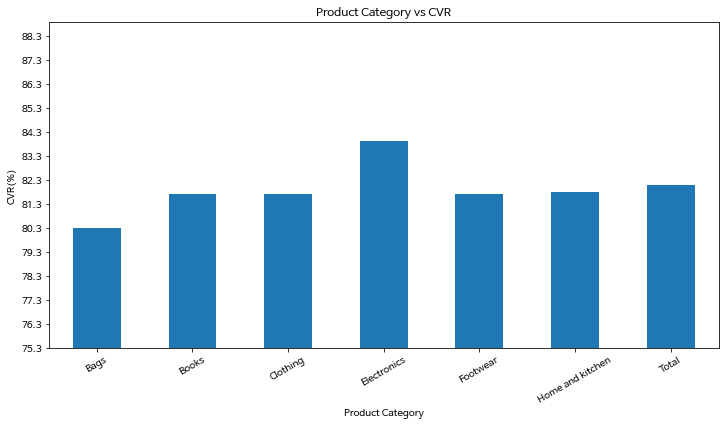

In [31]:
cvr["CVR(%)"].plot(kind="bar", figsize=(12, 6))

plt.xticks(rotation=30, horizontalalignment="center")
plt.ylim(min(cvr["CVR(%)"]) - 5, max(cvr["CVR(%)"])+5)
plt.yticks(np.arange(min(cvr["CVR(%)"] - 5), max(cvr["CVR(%)"]) + 5, 1))
plt.xlabel("Product Category")
plt.ylabel("CVR(%)")
plt.title("Product Category vs CVR")

plt.show()

In [32]:
cvr_subcat.index

MultiIndex([(            'Bags',                'Mens'),
            (            'Bags',               'Women'),
            (           'Books',            'Academic'),
            (           'Books',            'Children'),
            (           'Books',              'Comics'),
            (           'Books',                 'DIY'),
            (           'Books',             'Fiction'),
            (           'Books',         'Non-Fiction'),
            (        'Clothing',                'Kids'),
            (        'Clothing',                'Mens'),
            (        'Clothing',               'Women'),
            (     'Electronics',     'Audio and video'),
            (     'Electronics',             'Cameras'),
            (     'Electronics',           'Computers'),
            (     'Electronics',             'Mobiles'),
            (     'Electronics', 'Personal Appliances'),
            (        'Footwear',                'Kids'),
            (        'Footwear'

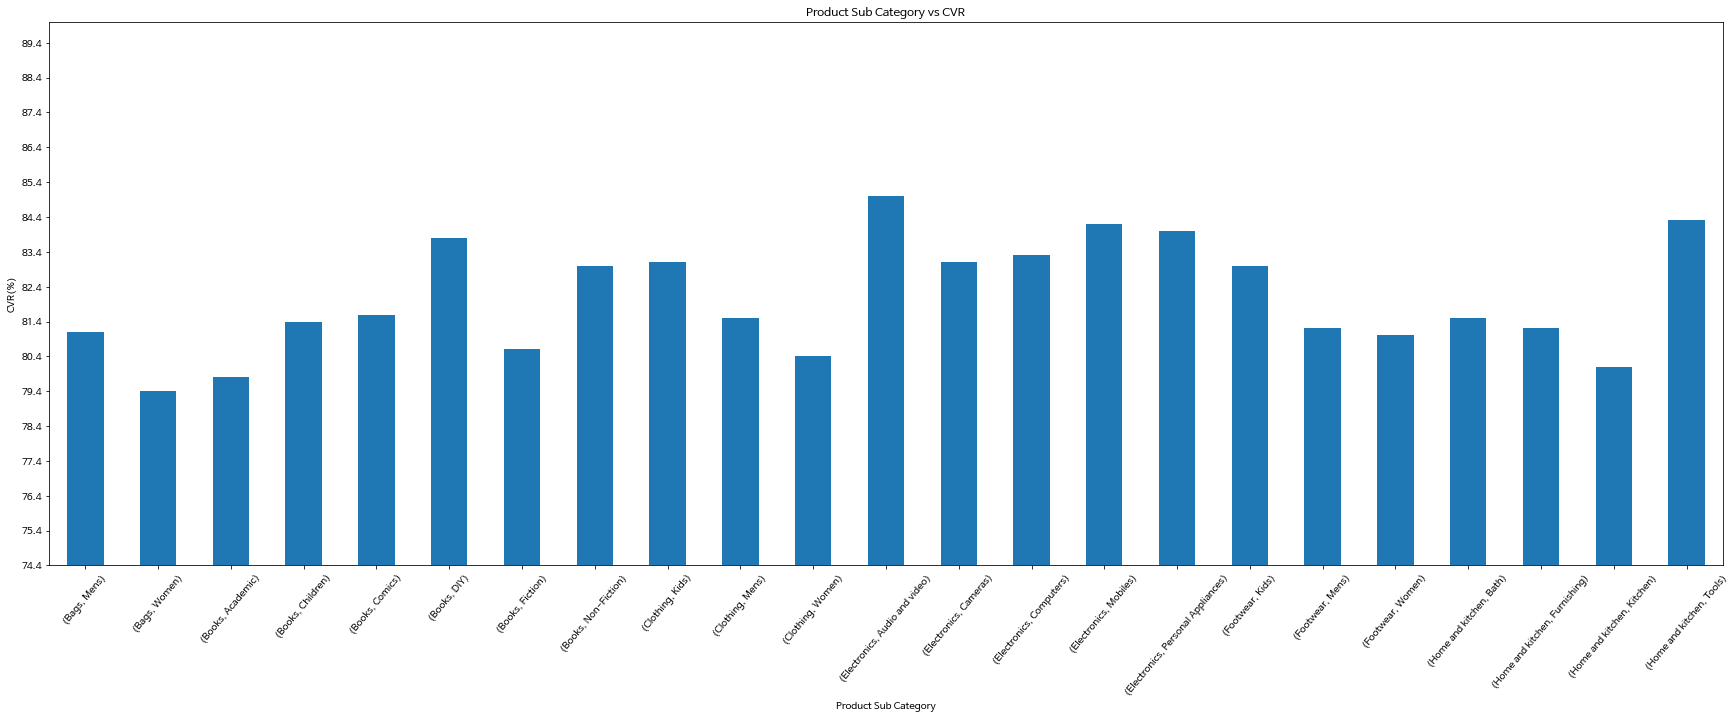

In [33]:
cvr_subcat["CVR(%)"].plot(kind="bar", figsize=(30, 10))

plt.xticks(rotation=50)
plt.ylim(min(cvr_subcat["CVR(%)"]) - 5, max(cvr_subcat["CVR(%)"])+5)
plt.yticks(np.arange(min(cvr_subcat["CVR(%)"] - 5), max(cvr_subcat["CVR(%)"]) + 5, 1))
plt.xlabel("Product Sub Category")
plt.ylabel("CVR(%)")
plt.title("Product Sub Category vs CVR")

plt.show()

In [34]:
min_cvr = min(cvr_subcat["CVR(%)"])
max_cvr = max(cvr_subcat["CVR(%)"])
avg_cvr = cvr["CVR(%)"][-1]

print("최대: ", max_cvr)
print("최소: ", min_cvr)
print("평균: ", avg_cvr)
print("최대 - 최소: ", round(max_cvr - min_cvr,2))
print("최대 - 평균: ", round(max_cvr - avg_cvr,2))
print("최소 - 평균: ", round(min_cvr - avg_cvr,2))

최대:  85.0
최소:  79.4
평균:  82.1
최대 - 최소:  5.6
최대 - 평균:  2.9
최소 - 평균:  -2.7


**결과 해석**
> * 상품 전환율이 높은 대 카테고리는 "Electronics"이며 서브 카테고리는 "Audio and video"이다
    * 이는 고관여 상품으로 분류되는 Electronics 카테고리가 상품 전환율이 크다라는 가설을 뒷받침 할 수 있는 근거이다.
    * 하지만 상품 전환율이 가장 높은 카테고리와 낮은 카테고리의 차이가 **5.6%**로 그 차이가 작고, 평균과의 편차도 작은 편이다.
* 그러므로 카테고리간의 상품 전환율 차이가 유의미하다고 보기 힘들다.

**새로운 질문**
> 1. 상품 전환율이 높았던 "Electronics" 카테고리가 다른 카테고리 대비 평균 판매가가 높은가 (고관여 상품인가)?
2. 평균 판매가와 상품 전환율 간 관계가 존재하는가?
    * 가격이 높을수록 상품 전환율이 높아지는지?










In [35]:
# CVR과 Rate의 랭크 구하기
cvr_new = pd.pivot_table(new_data,
               index=['prod_cat', 'prod_subcat'],
               columns=['confirmed'],
               values=["transaction_id", 'Rate'],
               aggfunc={'transaction_id':'count',
                        'Rate': np.mean})


# CVR 구하기
cvr_new["CVR(%)"] = ((cvr_new[('transaction_id', 'confirm')] / (cvr_new[('transaction_id', 'cancel')] + cvr_new[('transaction_id', 'confirm')])) * 100).round(1)

# CVR 순위
cvr_new["Rank CVR"] = cvr_new['CVR(%)'].rank(method='first', ascending=False)

# 평균 판매가 순위
cvr_new["Rank Rate"] = cvr_new[('Rate', 'confirm')].rank(method='first', ascending=False)
cvr_new.sort_values(['Rank CVR'], ascending=True, inplace=True)

display(cvr_new)

Rate             transaction_id  \
confirmed                            cancel     confirm         cancel   
prod_cat         prod_subcat                                             
Electronics      Audio and video        0.0  777.346154            142   
Home and kitchen Tools                  0.0  758.575450            166   
Electronics      Mobiles                0.0  784.963048            162   
                 Personal Appliances    0.0  783.213580            154   
Books            DIY                    0.0  780.661818            160   
Electronics      Computers              0.0  788.721106            160   
Clothing         Kids                   0.0  796.669927            166   
Electronics      Cameras                0.0  790.063804            166   
Books            Non-Fiction            0.0  784.143201            170   
Footwear         Kids                   0.0  771.872443            170   
Books            Comics                 0.0  783.027578            188   
Clothing         Mens                   0.0  784.222930            178   
Home and kitchen Bath                   0.0  773.162847            188   
Books            Children               0.0  800.467780            192   
Footwear         Mens                   0.0  789.713535            176   
Home and kitchen Furnishing             0.0  789.014778            188   
Bags             Mens                   0.0  807.241038            188   
Footwear         Women                  0.0  783.633886            198   
Books            Fiction                0.0  785.793802            202   
Clothing         Women                  0.0  779.740971            196   
Home and kitchen Kitchen                0.0  777.639324            206   
Books            Academic               0.0  802.975196            194   
Bags             Women                  0.0  777.772959            204   

                                             CVR(%) Rank CVR Rank Rate  
confirmed                            confirm                            
prod_cat         prod_subcat                                            
Electronics      Audio and video         806   85.0      1.0      20.0  
Home and kitchen Tools                   888   84.3      2.0      23.0  
Electronics      Mobiles                 866   84.2      3.0      10.0  
                 Personal Appliances     810   84.0      4.0      14.0  
Books            DIY                     825   83.8      5.0      16.0  
Electronics      Computers               796   83.3      6.0       8.0  
Clothing         Kids                    818   83.1      7.0       4.0  
Electronics      Cameras                 815   83.1      8.0       5.0  
Books            Non-Fiction             831   83.0      9.0      12.0  
Footwear         Kids                    831   83.0     10.0      22.0  
Books            Comics                  834   81.6     11.0      15.0  
Clothing         Mens                    785   81.5     12.0      11.0  
Home and kitchen Bath                    829   81.5     13.0      21.0  
Books            Children                838   81.4     14.0       3.0  
Footwear         Mens                    761   81.2     15.0       6.0  
Home and kitchen Furnishing              812   81.2     16.0       7.0  
Bags             Mens                    809   81.1     17.0       1.0  
Footwear         Women                   844   81.0     18.0      13.0  
Books            Fiction                 839   80.6     19.0       9.0  
Clothing         Women                   803   80.4     20.0      17.0  
Home and kitchen Kitchen                 829   80.1     21.0      19.0  
Books            Academic                766   79.8     22.0       2.0  
Bags             Women                   784   79.4     23.0      18.0

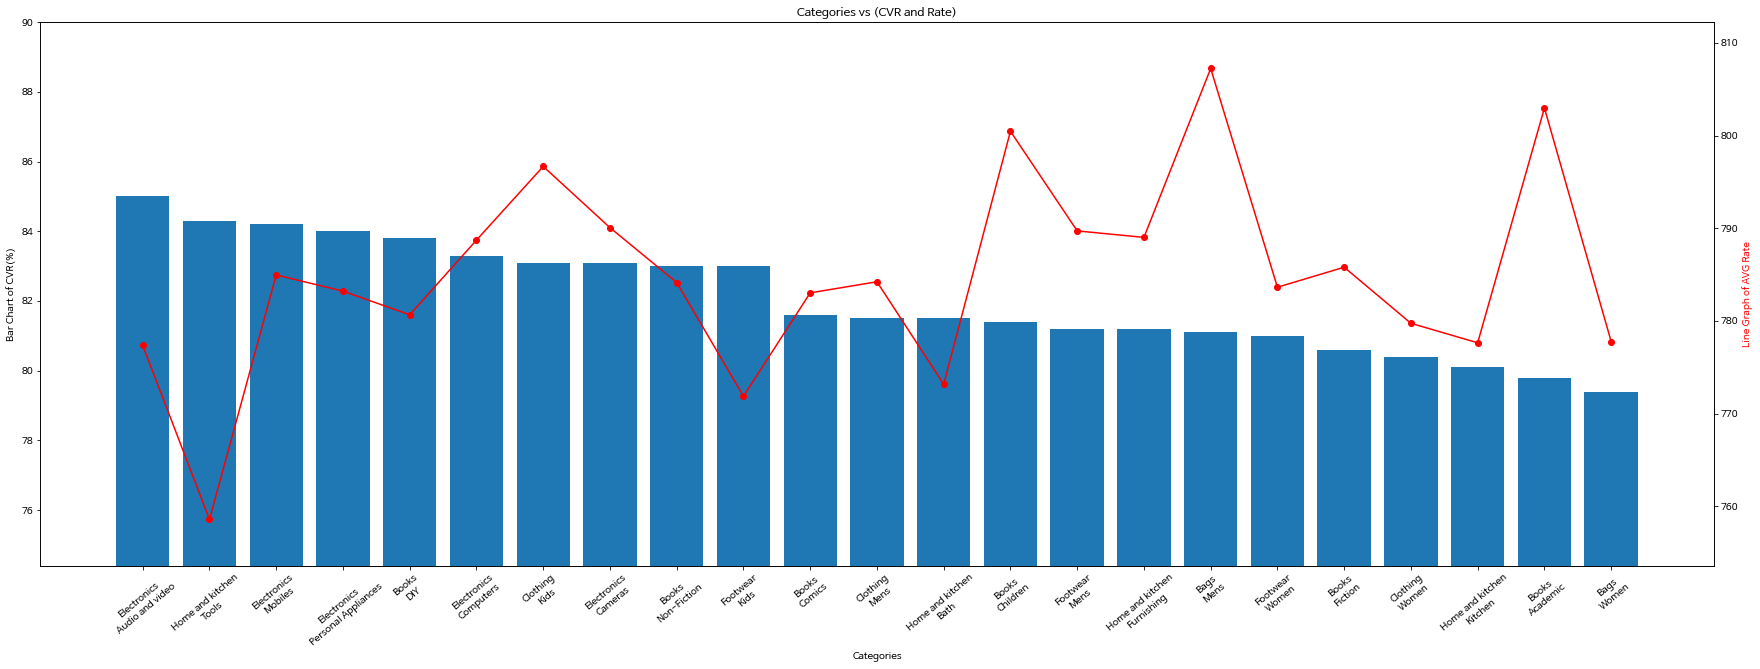

In [36]:
fig, ax1 = plt.subplots(figsize=(30,10))

x = cvr_new.index
x_cats = [f'{cat1}\n{cat2}' for cat1, cat2 in x]

y1 = cvr_new["CVR(%)"]
y2 = cvr_new[('Rate', 'confirm')]

x_pos = np.arange(len(x))
ax1.bar(x_pos, y1)
ax1.set_ylabel('Bar Chart of CVR(%)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_cats, rotation=40)
ax1.set_ylim(y1.min() - 5, y1.max() + 5)

ax2 = ax1.twinx()
ax2.plot(x_pos, y2, color='red', marker='o')
ax2.set_ylabel('Line Graph of AVG Rate', color='red')
ax2.set_ylim(y2.min() - 5, y2.max() + 5)

ax1.set_xlabel('Categories')
ax2.set_title('Categories vs (CVR and Rate)')

plt.show()


**결과 해석**



> 1. 고관여 상품군인 "Electronics"의 평균 판매가는 다른 카테고리의 평균 판매가 대비 높지 않다.
    * Electronics (Audio and video)의 상품 전환율은 1위이지만 평균 판매가는 20위이다
2. 평균 판매가와 상품 전환율 간 특별한 상관 관계가 보이지 않는다







## 2.b 카테고리별 매출

### 2.b.i CAGR (기하평균)

1. 각 카테고리 매해의 매출액 성장률

In [37]:
df_copy = new_data.copy()

# 2014년도는 2월달 데이터밖에 없기 때문에 year column을 만들어주고 2014년도 데이터는 제외한다
df_copy['year'] = df_copy['tran_date'].dt.year
years = [2011, 2012, 2013]
df_copy = df_copy[df_copy['tran_date'].dt.year.isin(years)]

In [38]:
# 카테고리별 연매출
cagr_table = pd.pivot_table(df_copy, 
                            index=['year'],
                            columns=["prod_cat"],
                            values=['total_amt'],
                            aggfunc='sum'
                            )

display(cagr_table)

total_amt                                                     \
prod_cat         Bags        Books     Clothing Electronics     Footwear   
year                                                                       
2011      1300524.225  4016183.275  1785959.565  3271600.02  1854123.700   
2012      1293580.405  4286794.460  2081752.595  3527106.96  2168097.295   
2013      1365521.430  4004893.490  2113756.710  3497565.89  1988425.400   

                           
prod_cat Home and kitchen  
year                       
2011          2608393.385  
2012          2645824.155  
2013          2838690.855

In [39]:
# 카테고리 별 CAGR
cagr = round(((cagr_table.iloc[-1] / cagr_table.iloc[0])**(1/len(cagr_table)) - 1) * 100, 2)

print(cagr)

           prod_cat        
total_amt  Bags                1.64
           Books              -0.09
           Clothing            5.78
           Electronics         2.25
           Footwear            2.36
           Home and kitchen    2.86
dtype: float64



**결과해석**
> 2011년부터 2013년까지의 카테고리별 CAGR를 구했을 때 **Clothing** 카테고리가 **5.78%**로  매출액 성장률이 제일 높았으며 **Book** 카테고리가 **-0.09%**로 성장률이 제일 저조했다.



### 2.b.ii 분산과 표준편차

**질문**


> 각 카테고리별 월평균 매출 추이에 대한 해석
1. 가장 월평균 매출익이 높은 카테고리는?
2. 카테고리별 월평균 매출액의 분산과 표준 편차는?
3. RSD(변동계수)를 이용한 해석?



In [40]:
# month column 추가
df_copy['month'] = df_copy['tran_date'].dt.month

In [41]:
# 카테고리별 년,월 매출
cagr_table_by_month = pd.pivot_table(df_copy, 
                            index=['year', 'month'],
                            columns=["prod_cat"],
                            values=['total_amt'],
                            aggfunc='sum'
                            )

display(cagr_table_by_month)

total_amt                                                  \
prod_cat          Bags       Books    Clothing Electronics    Footwear   
year month                                                               
2011 1       28925.585  111702.240   31618.470   69149.795   21522.085   
     2       69902.300  346154.510   85447.440  271062.025  132077.335   
     3      136553.690  398109.400  226052.060  312502.840  128654.045   
     4      177791.185  391319.175  121156.620  290001.725  150989.410   
     5       77536.745  292254.820  127848.500  294567.585  136403.410   
     6      106849.080  344164.405  138648.770  240738.615  164169.850   
     7      114181.860  322806.965  169181.025  318601.335  175052.995   
     8      104637.975  272441.065  164710.195  285537.525  184790.255   
     9      106411.500  405636.660  158533.245  288048.085  226548.205   
     10     109534.230  374459.085  154156.340  326394.900  214444.035   
     11     137172.490  395992.220  232512.995  309956.920  157317.745   
     12     131027.585  361142.730  176093.905  265038.670  162154.330   
2012 1       67400.580  358617.805  165869.340  263299.400  155990.640   
     2      141525.085  360411.220  183606.800  205204.025  192199.280   
     3      126329.125  391732.445  185439.995  303116.970  201157.515   
     4       78830.700  342116.840  180361.415  248525.550  178299.485   
     5      113459.190  357060.860  119661.555  320941.725  207585.300   
     6      107452.410  358760.350  166953.345  316672.005  156426.010   
     7      105731.925  358518.355  149667.830  263555.760  173361.240   
     8      100074.325  398404.435  128544.650  295917.895  198823.755   
     9      122582.070  381094.610  215986.615  274234.480  174230.875   
     10     114192.910  307452.990  172750.175  396988.930  198178.435   
     11      96905.185  338972.010  211878.225  305475.040  183245.465   
     12     119096.900  333652.540  201032.650  333175.180  148599.295   
2013 1      103137.385  304638.555  189569.380  330924.295  208891.410   
     2      128057.345  254481.500  195718.705  252505.760  148465.590   
     3      115878.035  393130.270  211903.640  339160.965  138483.020   
     4       82786.600  320760.505  159848.195  331024.850  139600.175   
     5      119573.155  368420.260  145141.750  275895.295  167547.835   
     6      119730.065  276128.450  144106.365  285430.340  165575.410   
     7      112264.685  343062.720  130300.495  326369.485  192190.440   
     8      119522.325  381221.685  203441.550  294222.825  205604.035   
     9      147956.185  314237.690  199300.010  259150.125  143676.520   
     10     110875.700  383848.270  171943.525  260976.690  164015.150   
     11     111083.440  341376.490  172270.605  280176.065  138667.555   
     12      94656.510  323587.095  190212.490  261729.195  175708.260   

                             
prod_cat   Home and kitchen  
year month                   
2011 1            74389.705  
     2           193276.655  
     3           182195.715  
     4           249760.940  
     5           265812.170  
     6           241718.750  
     7           221214.370  
     8           223009.995  
     9           261465.100  
     10          226878.600  
     11          222760.265  
     12          245911.120  
2012 1           198230.370  
     2           231298.600  
     3           239519.800  
     4           192910.900  
     5           240326.450  
     6           208388.635  
     7           201919.965  
     8           205497.955  
     9           168522.445  
     10          225984.655  
     11          248262.560  
     12          284961.820  
2013 1           245433.760  
     2           229044.400  
     3           269966.970  
     4           248103.440  
     5           210439.515  
     6           278679.895  
     7           136131.580  
     8           204254.830  
     9           282193.795  
     10          284474.515  
     11         

In [42]:
mean_ = round(cagr_table_by_month.mean(), 3)
var_ = cagr_table_by_month.var()
std_ = cagr_table_by_month.std()
rsd_ = round(std_/mean_, 3)

In [43]:
stats_df = pd.concat([mean_, var_, std_, rsd_], axis=1)
stats_df.columns = ['Mean', 'Variance', 'Std. Deviation', 'RSD']

display(stats_df)

Mean      Variance  Std. Deviation    RSD
          prod_cat                                                         
total_amt Bags              109989.613  6.715918e+08    25915.087426  0.236
          Books             341885.312  3.031870e+09    55062.414974  0.161
          Clothing          166151.913  1.618094e+09    40225.533948  0.242
          Electronics       286007.580  2.632264e+09    51305.597839  0.179
          Footwear          166962.400  1.287442e+09    35880.941662  0.215
          Home and kitchen  224803.011  1.769892e+09    42070.081901  0.187

**결과 해석**

1. 월매출 평균이 제일 높은 카테고리는 **Books** 카테고리이며, 제일 낮은 카테고리는 **Bags** 카테고리이다.
2. **표준 편차**로만 보았을 때 Book 카테고리의 매출액 변동성이 가장 큰 것처럼 보이지만 **RSD**를 이용하였을 때는 Book 카테고리는 매출액 변동성이 낮으면서 월평균 매출액이 가장 큰 카테고리다.
3. **따라서 Books 카테고리가 매출에 기여도가 크면서 안정적으로 매출이 발생하는 주력 카테고리라고 해석된다.**



## 2.c 고객 추천 (Not available ATM)

In [44]:
df_copy2 = new_data.copy()

# prod_cat과 prod_subcat을 합친 컬럼 만들기
df_copy2['category'] = df_copy2['prod_cat'] + '-' + df_copy2['prod_subcat']

# cust_id명을 customer 테이블의 customer_id와 똑같이 만들기
df_copy2.rename(columns={'cust_id':'customer_Id'}, inplace=True)

In [45]:
# transaction 테이블과 customer 테이블 조인 진행
# customer 테이블에서 gender와 age 컬럼만 가져오기

df2 = pd.merge(
    left = df_copy2,
    right = customer[['customer_Id', 'Gender', 'age']],
    on = ["customer_Id"],
    how = "left"
)

df2.head()

,transaction_id,customer_Id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,order_status,confirmed,key,chk,prod_cat,prod_subcat,category,Gender,age
0,8410316370,266783,2013-02-20,4,1,1,869,91.245,960.245,e-Shop,order,confirm,8410316370order,1,Clothing,Mens,Clothing-Mens,M,40
1,16999552161,266783,2013-02-09,10,5,2,835,175.350,1845.350,e-Shop,order,confirm,16999552161order,1,Books,Non-Fiction,Books-Non-Fiction,M,40
2,25890929042,266783,2011-09-23,1,2,4,1321,554.820,5838.820,e-Shop,order,cancel,25890929042order,1,Footwear,Mens,Footwear-Mens,M,40
3,25890929042,266783,2011-09-24,1,2,-4,-1321,554.820,-5838.820,e-Shop,cancel,cancel,25890929042cancel,1,Footwear,Mens,Footwear-Mens,M,40
4,98477711300,266783,2012-10-21,4,1,3,93,29.295,308.295,TeleShop,order,confirm,98477711300order,1,Clothing,Mens,Clothing-Mens,M,40


In [46]:
corr_pivot_table = pd.pivot_table(df2, 
                            index=['customer_Id'],
                            columns=["category"],
                            values=['transaction_id'],
                            aggfunc='count'
                            ).fillna(0)
display(corr_pivot_table)

transaction_id                                           \
category         Bags-Mens Bags-Women Books-Academic Books-Children   
customer_Id                                                           
266783                 0.0        0.0            0.0            0.0   
266784                 0.0        0.0            0.0            0.0   
266785                 1.0        0.0            0.0            1.0   
266788                 1.0        0.0            0.0            0.0   
266794                 1.0        1.0            1.0            1.0   
...                    ...        ...            ...            ...   
275257                 0.0        0.0            0.0            1.0   
275261                 0.0        2.0            0.0            1.0   
275262                 0.0        0.0            0.0            0.0   
275264                 0.0        0.0            0.0            0.0   
275265                 1.0        0.0            1.0            0.0   

                                                                    \
category    Books-Comics Books-DIY Books-Fiction Books-Non-Fiction   
customer_Id                                                          
266783               0.0       0.0           0.0               1.0   
266784               0.0       0.0           1.0               1.0   
266785               0.0       0.0           0.0               0.0   
266788               0.0       0.0           1.0               0.0   
266794               0.0       0.0           0.0               0.0   
...                  ...       ...           ...               ...   
275257               0.0       0.0           0.0               0.0   
275261               2.0       0.0           0.0               0.0   
275262               0.0       0.0           0.0               0.0   
275264               0.0       0.0           0.0               1.0   
275265               0.0       0.0           0.0               0.0   

                                         ...                        \
category    Clothing-Kids Clothing-Mens  ... Electronics-Computers   
customer_Id                              ...                         
266783                0.0           2.0  ...                   0.0   
266784                0.0           0.0  ...                   0.0   
266785                0.0           0.0  ...                   0.0   
266788                0.0           0.0  ...                   0.0   
266794                2.0           0.0  ...                   0.0   
...                   ...           ...  ...                   ...   
275257                0.0           0.0  ...                   0.0   
275261                0.0           0.0  ...                   0.0   
275262                0.0           1.0  ...                   0.0   
275264                0.0           0.0  ...                   0.0   
275265                0.0           0.0  ...                   0.0   

                                                                               \
category    Electronics-Mobiles Electronics-Personal Appliances Footwear-Kids   
customer_Id                                                                     
266783                      0.0                             0.0           0.0   
266784                      1.0                             0.0           0.0   
266785                      0.0                             0.0           2.0   
266788                      0.0                             0.0           1.0   
266794                      0.0                             1.0           0.0   
...                         ...                             ...           ...   
275257                      0.0                             0.0           0.0   
275261                      0.0                             0.0           0.0   
275262                      0.0                             0.0           0.0   
275264                      0.0                             0.0           0.0   
27

## 2.d Z 차트


**질문**
> Z 차트를 이용한 2013년 매출추이 시계열 분석 및 해석
> 1. 월별 매출
> 2. 누계 매출
> 3. 이동 합계



In [47]:
# 카테고리별 월 매출
sales_by_month = pd.pivot_table(df_copy, 
                            index=['year', 'month'],
                            columns=["prod_cat"],
                            values=['total_amt'],
                            aggfunc='sum'
                            )

In [48]:
# 2013년 월별 매출
sales_2013 = sales_by_month.loc[2013]

# 2013년 누계 매출
cum_sales = sales_2013.cumsum()

# 2013년 이동 합계
moving_sum = sales_by_month.rolling(window=12).sum().loc[2013]

In [49]:
# 카테고리별 월별 매출, 누계 매출, 이동 합계를 한 테이블에 합치기
combined_df = pd.DataFrame()
col_names = []
for col in moving_sum.columns:
    new_cols = pd.MultiIndex.from_product([[col[1]], ['월별 매출','누계 매출', '이동 합계']])
    new_df = pd.concat([sales_2013[col], cum_sales[col], moving_sum[col]], axis=1)
    new_df.columns = pd.MultiIndex.from_tuples(new_cols)
    combined_df = pd.concat([combined_df, new_df], axis=1)

display(combined_df)

Bags                                 Books               \
            월별 매출        누계 매출        이동 합계       월별 매출        누계 매출   
month                                                                  
1      103137.385   103137.385  1329317.210  304638.555   304638.555   
2      128057.345   231194.730  1315849.470  254481.500   559120.055   
3      115878.035   347072.765  1305398.380  393130.270   952250.325   
4       82786.600   429859.365  1309354.280  320760.505  1273010.830   
5      119573.155   549432.520  1315468.245  368420.260  1641431.090   
6      119730.065   669162.585  1327745.900  276128.450  1917559.540   
7      112264.685   781427.270  1334278.660  343062.720  2260622.260   
8      119522.325   900949.595  1353726.660  381221.685  2641843.945   
9      147956.185  1048905.780  1379100.775  314237.690  2956081.635   
10     110875.700  1159781.480  1375783.565  383848.270  3339929.905   
11     111083.440  1270864.920  1389961.820  341376.490  3681306.395   
12      94656.510  1365521.430  1365521.430  323587.095  4004893.490   

                      Clothing                           Electronics  \
             이동 합계       월별 매출        누계 매출        이동 합계       월별 매출   
month                                                                  
1      4232815.210  189569.380   189569.380  2105452.635  330924.295   
2      4126885.490  195718.705   385288.085  2117564.540  252505.760   
3      4128283.315  211903.640   597191.725  2144028.185  339160.965   
4      4106926.980  159848.195   757039.920  2123514.965  331024.850   
5      4118286.380  145141.750   902181.670  2148995.160  275895.295   
6      4035654.480  144106.365  1046288.035  2126148.180  285430.340   
7      4020198.845  130300.495  1176588.530  2106780.845  326369.485   
8      4003016.095  203441.550  1380030.080  2181677.745  294222.825   
9      3936159.175  199300.010  1579330.090  2164991.140  259150.125   
10     4012554.455  171943.525  1751273.615  2164184.490  260976.690   
11     4014958.935  172270.605  1923544.220  2124576.870  280176.065   
12     4004893.490  190212.490  2113756.710  2113756.710  261729.195   

                                   Footwear                            \
             누계 매출        이동 합계       월별 매출        누계 매출        이동 합계   
month                                                                   
1       330924.295  3594731.855  208891.410   208891.410  2220998.065   
2       583430.055  3642033.590  148465.590   357357.000  2177264.375   
3       922591.020  3678077.585  138483.020   495840.020  2114589.880   
4      1253615.870  3760576.885  139600.175   635440.195  2075890.570   
5      1529511.165  3715530.455  167547.835   802988.030  2035853.105   
6      1814941.505  3684288.790  165575.410   968563.440  2045002.505   
7      2141310.990  3747102.515  192190.440  1160753.880  2063831.705   
8      2435533.815  3745407.445  205604.035  1366357.915  2070611.985   
9      2694683.940  3730323.090  143676.520  1510034.435  2040057.630   
10     2955660.630  3594310.850  164015.150  1674049.585  2005894.345   
11     3235836.695  3569011.875  138667.555  1812717.140  1961316.435   
12     3497565.890  3497565.890  175708.260  1988425.400  1988425.400   

      Home and kitchen                            
                 월별 매출        누계 매출        이동 합계  
month                                             
1           245433.760   245433.760  2693027.545  
2           229044.400   474478.160  2690773.345  
3           269966.970   744445.130  2721220.515  
4           248103.440   992548.570  2776413.055  
5           210439.515  1202988.085  2746526.120  
6           278679.895  1481667.980  2816817.380  
7           136131.580  1617799.560  2751028.995  
8           204254.830  1822054.390  2749785.870  
9           282193.795  2104248.185  2863457.220  
10          284474.515  2388722.700  2921947.080  
11          232265.475  2620988.175  2905949.995  
12          217702.680  2838690.855  2838

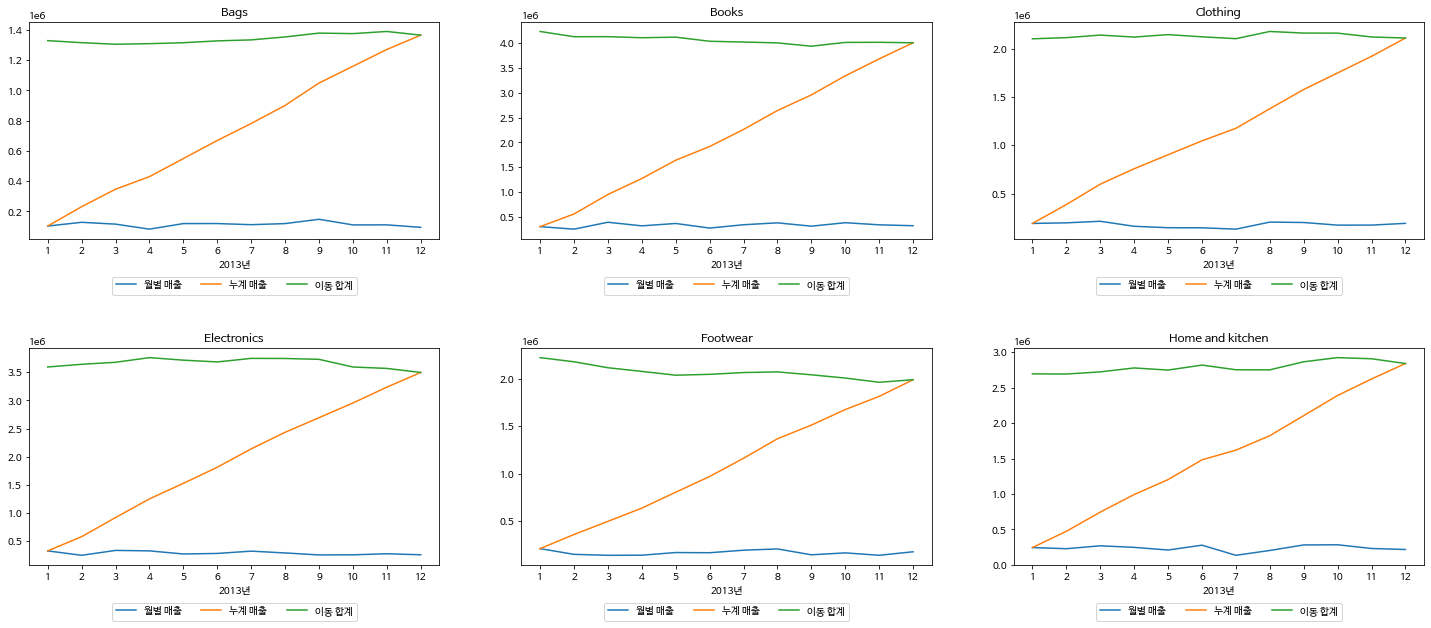

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0, 0].plot(combined_df.index, combined_df[('Bags', '월별 매출')], label='월별 매출')
axes[0, 0].plot(combined_df.index, combined_df[('Bags', '누계 매출')], label='누계 매출')
axes[0, 0].plot(combined_df.index, combined_df[('Bags', '이동 합계')], label='이동 합계')
axes[0, 0].set_title("Bags")
axes[0, 0].set_xticks(range(1,13,1))
axes[0, 0].set_xlabel('2013년')
axes[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

axes[0, 1].plot(combined_df.index, combined_df[('Books', '월별 매출')], label='월별 매출')
axes[0, 1].plot(combined_df.index, combined_df[('Books', '누계 매출')], label='누계 매출')
axes[0, 1].plot(combined_df.index, combined_df[('Books', '이동 합계')], label='이동 합계')
axes[0, 1].set_title("Books")
axes[0, 1].set_xticks(range(1,13,1))
axes[0, 1].set_xlabel('2013년')
axes[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

axes[0, 2].plot(combined_df.index, combined_df[('Clothing', '월별 매출')], label='월별 매출')
axes[0, 2].plot(combined_df.index, combined_df[('Clothing', '누계 매출')], label='누계 매출')
axes[0, 2].plot(combined_df.index, combined_df[('Clothing', '이동 합계')], label='이동 합계')
axes[0, 2].set_title("Clothing")
axes[0, 2].set_xticks(range(1,13,1))
axes[0, 2].set_xlabel('2013년')
axes[0, 2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

axes[1, 0].plot(combined_df.index, combined_df[('Electronics', '월별 매출')], label='월별 매출')
axes[1, 0].plot(combined_df.index, combined_df[('Electronics', '누계 매출')], label='누계 매출')
axes[1, 0].plot(combined_df.index, combined_df[('Electronics', '이동 합계')], label='이동 합계')
axes[1, 0].set_title("Electronics")
axes[1, 0].set_xticks(range(1,13,1))
axes[1, 0].set_xlabel('2013년')
axes[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

axes[1, 1].plot(combined_df.index, combined_df[('Footwear', '월별 매출')], label='월별 매출')
axes[1, 1].plot(combined_df.index, combined_df[('Footwear', '누계 매출')], label='누계 매출')
axes[1, 1].plot(combined_df.index, combined_df[('Footwear', '이동 합계')], label='이동 합계')
axes[1, 1].set_title("Footwear")
axes[1, 1].set_xticks(range(1,13,1))
axes[1, 1].set_xlabel('2013년')
axes[1, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

axes[1, 2].plot(combined_df.index, combined_df[('Home and kitchen', '월별 매출')], label='월별 매출')
axes[1, 2].plot(combined_df.index, combined_df[('Home and kitchen', '누계 매출')], label='누계 매출')
axes[1, 2].plot(combined_df.index, combined_df[('Home and kitchen', '이동 합계')], label='이동 합계')
axes[1, 2].set_title("Home and kitchen")
axes[1, 2].set_xticks(range(1,13,1))
axes[1, 2].set_xlabel('2013년')
axes[1, 2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)


**결과 해석**

> Bags와 Home and kitchen 카테고리는 점차적으로 매출이 **상승**<br>
> Clothing과 Electronics는 월별로는 차이가 있지만 전반적으로 매출이 **보합세**.<br>
> Books와 Footwear는 연초보다 연말에 매출이 **하락**.

## 2.e ABC 매출 등급 분석

>2013년 매출 등급 (누적 구성비 기준)
>>A등급 : 상위 50%<br>
>>B등급 : 상위 80%<br>
>>C등급 : 상위 100%

In [51]:
# 카테고리별 월 매출
df_2013 = df_copy[df_copy["year"] == 2013]

abc_table = pd.pivot_table(df_2013, 
                            index=['Store_type', 'prod_cat'],
                            values=['total_amt'],
                            aggfunc='sum'
                            )

In [52]:
# 구성비
abc_table['구성비(%)'] = round((abc_table['total_amt'] / abc_table['total_amt'].sum()) * 100, 1)
abc_table.sort_values('구성비(%)', ascending=False, inplace=True)

# 누적 구성비
abc_table['누적 구성비(%)'] = abc_table["구성비(%)"].cumsum()

# 등급 나누기
abc_table['등급'] = abc_table['누적 구성비(%)'].apply(lambda x: 'A' if x <= 50 else ('B' if x <= 80 else 'C'))

display(abc_table)

total_amt  구성비(%)  누적 구성비(%) 등급
Store_type     prod_cat                                           
e-Shop         Books             1685657.610    10.7       10.7  A
               Electronics       1455978.940     9.2       19.9  A
               Home and kitchen  1121403.725     7.1       27.0  A
               Clothing           891415.655     5.6       32.6  A
Flagship store Books              833740.180     5.3       37.9  A
e-Shop         Footwear           811158.400     5.1       43.0  A
Flagship store Electronics        794657.435     5.0       48.0  A
MBR            Books              768024.725     4.9       52.9  B
TeleShop       Books              717470.975     4.5       57.4  B
MBR            Electronics        673032.295     4.3       61.7  B
TeleShop       Home and kitchen   587474.355     3.7       65.4  B
MBR            Home and kitchen   566082.660     3.6       69.0  B
Flagship store Home and kitchen   563730.115     3.6       72.6  B
TeleShop       Electronics        573897.220     3.6       76.2  B
e-Shop         Bags               543831.275     3.4       79.6  B
TeleShop       Clothing           433358.900     2.7       82.3  C
Flagship store Clothing           417933.100     2.6       84.9  C
               Footwear           407405.765     2.6       87.5  C
TeleShop       Footwear           393397.680     2.5       90.0  C
MBR            Footwear           376463.555     2.4       92.4  C
               Clothing           371049.055     2.3       94.7  C
Flagship store Bags               276812.445     1.8       96.5  C
MBR            Bags               270475.270     1.7       98.2  C
TeleShop       Bags               274402.440     1.7       99.9  C

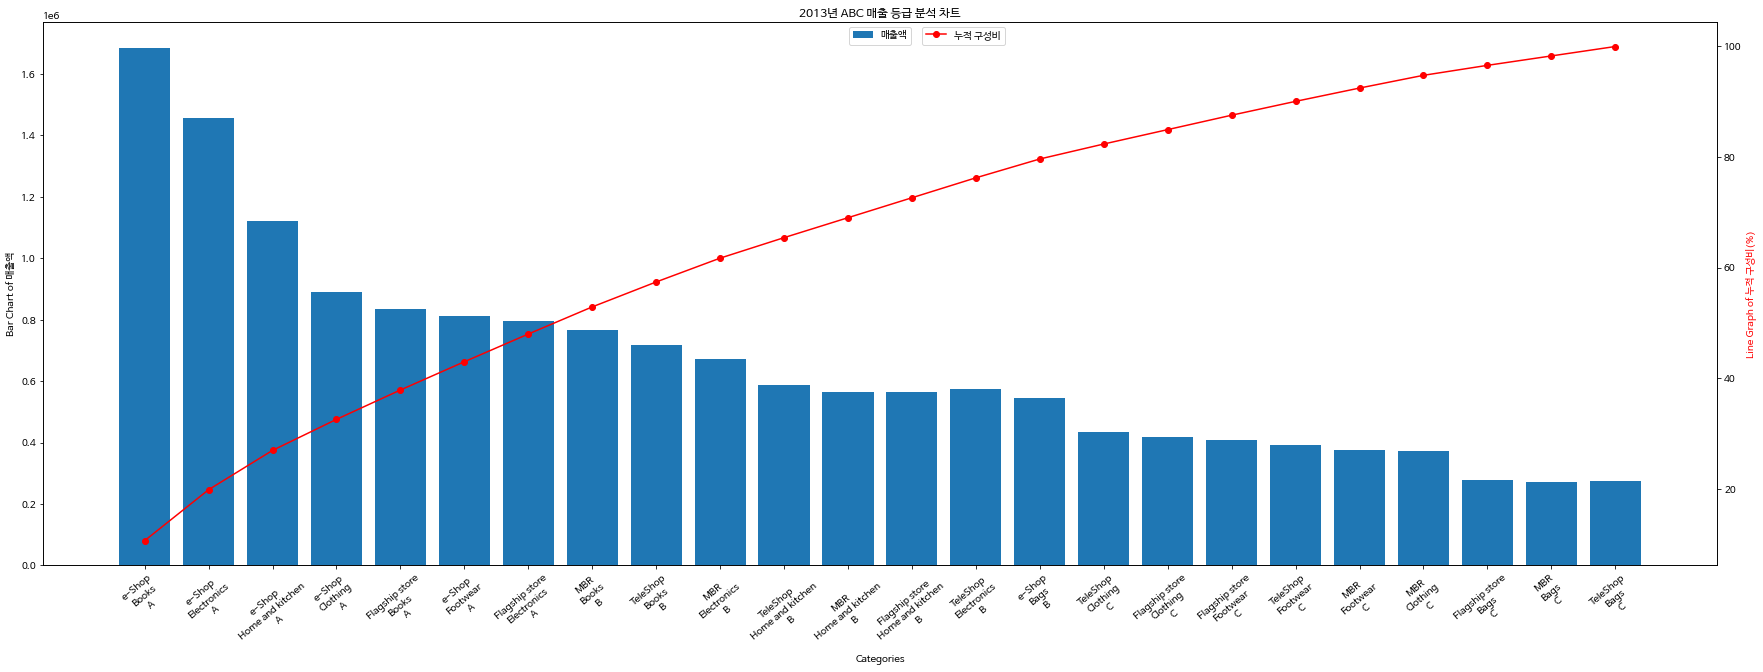

In [53]:
fig, ax1 = plt.subplots(figsize=(30,10))

x = abc_table.index
x_cats = []

for cat1, cat2 in x:
    rank = abc_table.loc[(cat1,cat2)]['등급']
    x_cats.append(f'{cat1}\n{cat2}\n{rank}')

y1 = abc_table["total_amt"]
y2 = abc_table['누적 구성비(%)']

x_pos = np.arange(len(x))
ax1.bar(x_pos, y1, label="매출액")
ax1.set_ylabel('Bar Chart of 매출액')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_cats, rotation=40)

ax2 = ax1.twinx()
ax2.plot(x_pos, y2, color='red', marker='o', label='누적 구성비')
ax2.set_ylabel('Line Graph of 누적 구성비(%)', color='red')

ax1.set_xlabel('Categories')
ax2.set_title('2013년 ABC 매출 등급 분석 차트')

ax1.legend(loc='upper center')
ax2.legend(loc='upper center', bbox_to_anchor=(0.55, 1))
plt.show()

**결과 해석**


> 1. 총 매출의 50%를 차지하는 A등급 카테고리는 총 7개로 그 중 5개는 온라인 **e-shop**에서 발생
> 2. 그 중 e-shop에서 생긴 **Books** 카테고리는 구성비가 10.7%를 차지하며 제일 매출 기여도가 높다
* 판매 촉진을 위한 광고비를 지출해야 한다면, e-shop에서의 광고, 특히 주력 카테고리인 Books와 Electronics을 중심으로 예산을 편성하여 운영
* 균형있는 매출을 위해 Bags와 Footwear 카테고리에 대해 매출 활성화 전략 필요



## 2.f 구매주기 경과 고객 추출 (CRM)

1. 각 고객의 구매주기 계산
2. 구매주기가 경과일이 앞뒤 30일인 고객 추출 (현재 날짜가 2014.03.01이라고 가정)

In [54]:
# 현재 날짜
today = '2014-03-01'

In [55]:
# 구매확정 거래건 대상 분석
df_copy3 = df_copy[df_copy['confirmed'] == 'confirm'].drop('chk', axis=1).sort_values(['cust_id', 'tran_date'])

# cust_id가 달라지면 1을 반환 (chk가 1인 행은 해당 고객의 최종 구매일)
df_copy3['chk'] = np.where(df_copy3['cust_id'] != df_copy3['cust_id'].shift(-1), 1, 0)

# cust_id와 tran_date를 하나로 묶어 구분할 수 있는 고유 key값 생성하고 중복이 아닌 구매일수 계산
key = map(lambda id, date : str(id) + '-' + str(date.strftime("%Y-%m-%d")), df_copy3["cust_id"], df_copy3["tran_date"])
df_copy3["key"] = list(key)
df_copy3['구매일수'] = np.where(df_copy3['key'] != df_copy3['key'].shift(-1), 1, 0)

# 누적 구매일수
df_copy3['누적 구매일수'] = df_copy3.groupby('cust_id')['구매일수'].cumcount() + 1

# diff로 각 구매일수간의 가격을 구한 후 NaT를 0초로 처리한 후 모든 수 int 타입으로 변경
df_copy3['구매일수 간격'] = df_copy3.groupby('cust_id')['tran_date'].diff().fillna(pd.Timedelta(seconds=0)).dt.days.astype(int)

# 최종 구매일자 - 최초 구매일자 계산
df_copy3['최종-최초'] = df_copy3.groupby('cust_id')['구매일수 간격'].cumsum()

In [56]:
# 고객의 마지막 거래건 추출 & 누적 구매일수가 1인 행은 최종 간격이 0이기 때문에 무시
# 누적 구매일수와 구매 최종 간격 값 가져오기

cycle_df = pd.pivot_table(df_copy3[(df_copy3['chk'] == 1) & (df_copy3['누적 구매일수'] != 1)],
               index=['cust_id', 'tran_date'],
               values=['누적 구매일수', '최종-최초'],
               aggfunc=['sum']
               )

# 구매 간격 / (누적 구매일수 - 1)를 구해서 구매주기 구하기
cycle_df['구매주기'] = cycle_df[('sum','최종-최초')] / (cycle_df[('sum','누적 구매일수')] - 1)

# 최종 구매일자에서 구매주기를 더해 다음 구매 예상일 구하기
cycle_df['구매 예상일'] = cycle_df.index.get_level_values('tran_date') + pd.to_timedelta(cycle_df['구매주기'], unit='d')
cycle_df['구매 예상일'] = cycle_df['구매 예상일'].apply(lambda x: x.strftime('%Y-%m-%d'))

# 현재 날짜가 2014.03.01이라는 가정하에 날짜 경과일수 구하기
# 계산하기 쉽게 int로 변환
# 현재 날짜보다 전이면 마이너스, 지났다면 플러스로 표현
cycle_df['경과일수'] = pd.to_datetime(today) - pd.to_datetime(cycle_df['구매 예상일'])
cycle_df['경과일수'] = cycle_df['경과일수'].dt.days.astype(int)

display(cycle_df)

sum              구매주기      구매 예상일 경과일수
                   누적 구매일수 최종-최초                             
cust_id tran_date                                            
266783  2013-02-20       3   122   61.000000  2013-04-22  313
266784  2012-12-04       3   103   51.500000  2013-01-24  401
266785  2013-08-01       6   870  174.000000  2014-01-22   38
266788  2013-02-12       4   611  203.666667  2013-09-03  179
266794  2012-11-27       9   620   77.500000  2013-02-12  382
...                    ...   ...         ...         ...  ...
275252  2013-12-24       8   972  138.857143  2014-05-11  -71
275257  2013-02-26       3   449  224.500000  2013-10-08  144
275262  2012-02-29       2   200  200.000000  2012-09-16  531
275264  2011-10-08       2    64   64.000000  2011-12-11  811
275265  2013-04-03       3   473  236.500000  2013-11-25   96

[4650 rows x 5 columns]

In [57]:
# 경과일수가 30일보다 크거나 작은 고객들만 추출
cycle_df[(cycle_df['경과일수'] <= 30) & (cycle_df['경과일수'] >= -30)]

sum              구매주기      구매 예상일 경과일수
                   누적 구매일수 최종-최초                             
cust_id tran_date                                            
266815  2013-07-02       3   545  272.500000  2014-03-31  -30
266823  2013-08-17       3   446  223.000000  2014-03-28  -27
266827  2013-09-02       5   777  194.250000  2014-03-15  -14
266830  2013-04-27       3   636  318.000000  2014-03-11  -10
266835  2013-02-19       3   746  373.000000  2014-02-27    2
...                    ...   ...         ...         ...  ...
275129  2013-11-19       2   105  105.000000  2014-03-04   -3
275165  2013-09-17       4   419  139.666667  2014-02-03   26
275167  2013-05-11       4   805  268.333333  2014-02-03   26
275184  2013-05-30       3   553  276.500000  2014-03-02   -1
275222  2013-09-16       2   175  175.000000  2014-03-10   -9

[486 rows x 5 columns]

**결과 해석**
1. 현재일이 2014년 03월 01일이라는 가정하에 구매 예상일 경과일수가 30일 전후인 고개들만 추출한 결과 총 **486**명이 추출됨
2. 해당 고객들에게 푸쉬 알림을 보내 구매 전환을 **유도**


---

# **3. 퍼널 분석**

> 전체 서비스에 가입한 고객중 2013년 하반기 (7월~12월) 기간 동안 구매한 고객과 상품을 취소하지 않고 구매를 확정한 고객의 퍼널별 실적 차트

In [58]:
df_copy4 = new_data.copy()

# 2013년 하반기 (7월~12월) 구매고객
df_copy4 = df_copy4[(df_copy4["tran_date"] >= '2013-07-01') & (df_copy4["tran_date"] < '2014-01-01')]

In [59]:
# 전체 고객 수
len_customer = len(customer)

# 2013 하반기 구매 고객 수
first_funnel = len(pd.pivot_table(df_copy4,
                                index=["cust_id"],
                                values=["transaction_id"],
                                aggfunc=["count"]))

# 2013 하반기 구매 최종 확정 고객 수
second_funnel = len(pd.pivot_table(df_copy4[df_copy4['confirmed'] == 'confirm'],
                                index=["cust_id"],
                                values=["transaction_id"],
                                aggfunc=["count"]))

# 첫번째 퍼널 전환율
first_funnel_ratio = round((first_funnel / len_customer)*100, 1)

# 두번째 퍼널 전환율
second_funnel_ratio = round((second_funnel / first_funnel)*100, 1)

In [60]:
data = [[len_customer, 0], [first_funnel, first_funnel_ratio], [second_funnel, second_funnel_ratio]]
index = ['전체 가입자', '2013 하반기 구매고객수', '2013 하반기 구매확정 고객수']
df_funnel = pd.DataFrame(data, index=index, columns=['고객수', '전환율(%)'])

# 비대상 고객의 수 계산
df_funnel['비대상'] = df_funnel['고객수'].shift(1) - df_funnel['고객수']
df_funnel['비대상'] = df_funnel['비대상'].fillna(0)

display(df_funnel)

,고객수,전환율(%),비대상
전체 가입자,5647,0.0,0.0
2013 하반기 구매고객수,2591,45.9,3056.0
2013 하반기 구매확정 고객수,2394,92.4,197.0


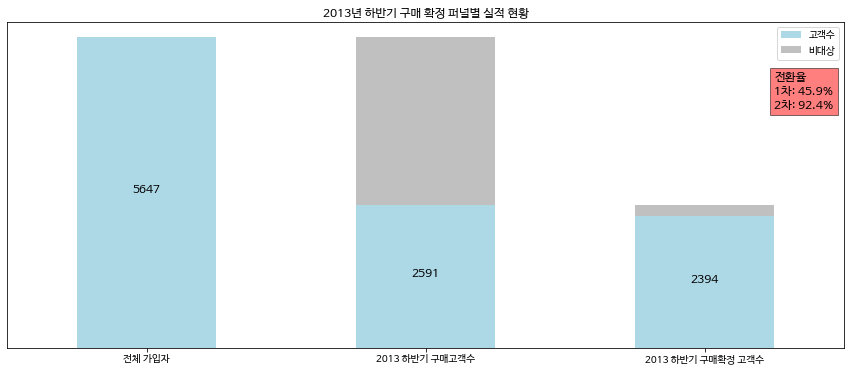

In [117]:
fig, ax = plt.subplots(figsize=(15, 6))

df_funnel[["고객수", "비대상"]].plot(kind='bar', stacked=True, color=['#ADD8E6', '#C0C0C0'], ax=ax)

ax.set_xticklabels(df_funnel.index, rotation=0)
ax.set_title("2013년 하반기 구매 확정 퍼널별 실적 현황")
ax.set_yticks([])

for i, val in enumerate(df_funnel['고객수']):
    ax.annotate(str(val), xy=(i, val/2), ha='center', fontsize=12)

plt.text(2.25, 4300,
         f'전환율\n1차: {df_funnel["전환율(%)"][1]}%\n2차: {df_funnel["전환율(%)"][2]}%',
         ha='left', va='bottom', fontsize=12,
         bbox=dict(facecolor='red', alpha=0.5))

plt.show()

**결과 해석**<br>
> 2013년 하반기에는 **첫번째 퍼널**에서 전체 가입자 중 **45.9%**에 해당하는 2591명이 구매로 전환되었고<br>
**두번째 퍼널**에서 그중 **92.4%**에 해당하는 2394명이 구매확정으로 전환되었다



---


# **4. 코호트 분석**